In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression

In [5]:
data_dir = "./data"
virgo_file = "VIRGO_Level1.txt"
results_dir = os.path.join(data_dir, "analysis")

data = load_data(os.path.join(data_dir, virgo_file))

t = data["timestamp"]  # Time in mission days
pmo_a = data["pmo6v_a"]
pmo_b = data["pmo6v_b"]
temp = data["temperature"]

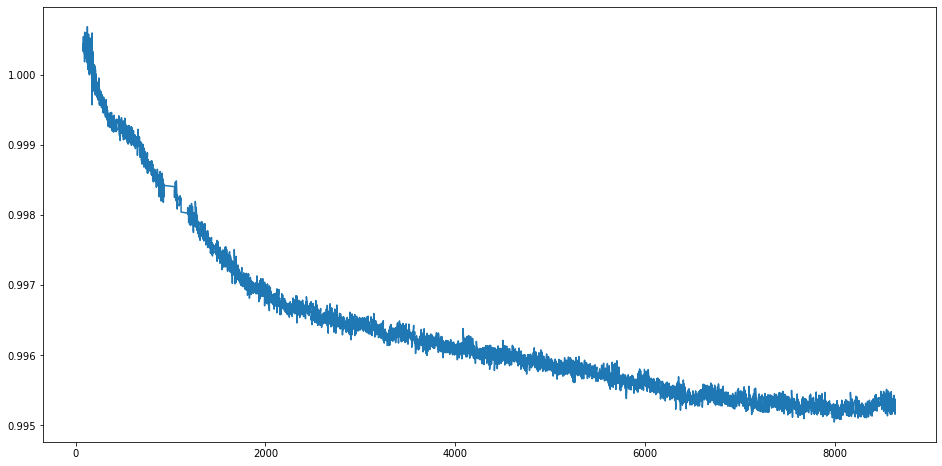

min ratio_a_b 0.9950485875656556


In [78]:

# data["exposure_a"] = compute_exposure(t, pmo_a)
# data["exposure_b"] = compute_exposure(t, pmo_b)
data["exposure_a"] = compute_exposure(t, pmo_a, "exposure_sum", mean_b)
data["exposure_b"] = compute_exposure(t, pmo_b, "exposure_sum", mean_b)

data_nn = data[["timestamp", "pmo6v_a", "pmo6v_b", "exposure_a", "exposure_b"]].dropna()
t_nn = data_nn["timestamp"].values
e_a_nn = data_nn["exposure_a"].values
e_b_nn = data_nn["exposure_b"].values
x_a_nn = data_nn["pmo6v_a"].values
x_b_nn = data_nn["pmo6v_b"].values

ratio_a_b = x_a_nn/x_b_nn

plt.figure(1, figsize=(16, 8))
plt.plot(t_nn, ratio_a_b)
plt.savefig(os.path.join(results_dir, "ratio_a_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

print("min ratio_a_b", ratio_a_b.min())

# data.sample(15, random_state=2)

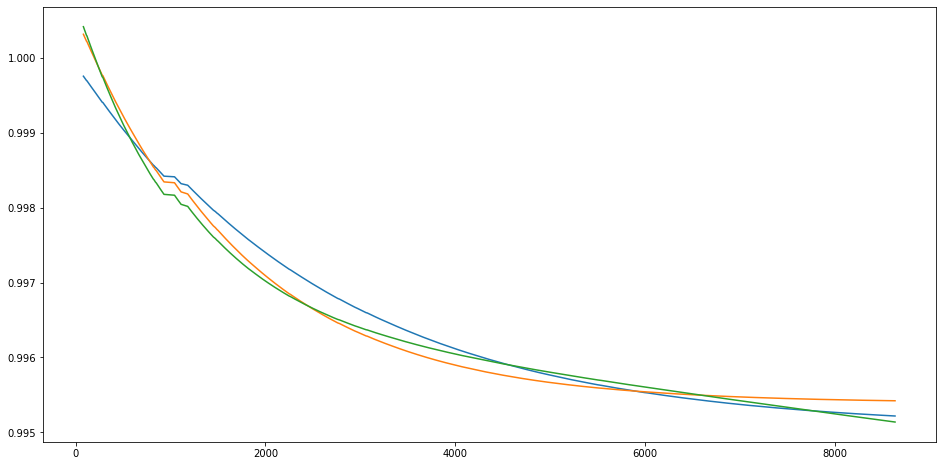

In [79]:
epsilon = 1e-5
gamma = ratio_a_b.min()

Y = np.log(ratio_a_b - gamma + epsilon)
X = e_a_nn.reshape(-1, 1)

regressor = LinearRegression(fit_intercept=True)
regressor.fit(X, Y)

a = regressor.coef_[0]
b = regressor.intercept_

lambda_ = -a
t_0 = b / lambda_

ratio_a_b_pred = gamma + np.exp(-lambda_ * (e_a_nn - t_0))


def exponential_linear_model(x, gamma, lambda_, t_0, linear):
    return np.exp(-lambda_ * (x - t_0)) + gamma + linear * x

def exponential_model(x, gamma, lambda_, t_0):
    return np.exp(-lambda_ * (x - t_0)) + gamma

popt, pcov = curve_fit(exponential_model,  e_a_nn,  ratio_a_b, p0=(gamma, lambda_, t_0))
popt_lin, pcov = curve_fit(exponential_linear_model,  e_a_nn,  ratio_a_b, p0=(gamma, lambda_, t_0, 0))


plt.figure(2, figsize=(16, 8))
# plt.plot(t_nn, ratio_a_b, t_nn, ratio_a_b_pred, t_nn, exponential_model(e_a_nn, *popt))
plt.plot(t_nn, ratio_a_b_pred, t_nn, exponential_model(e_a_nn, *popt), 
         t_nn, exponential_linear_model(e_a_nn, *popt_lin))
plt.show()

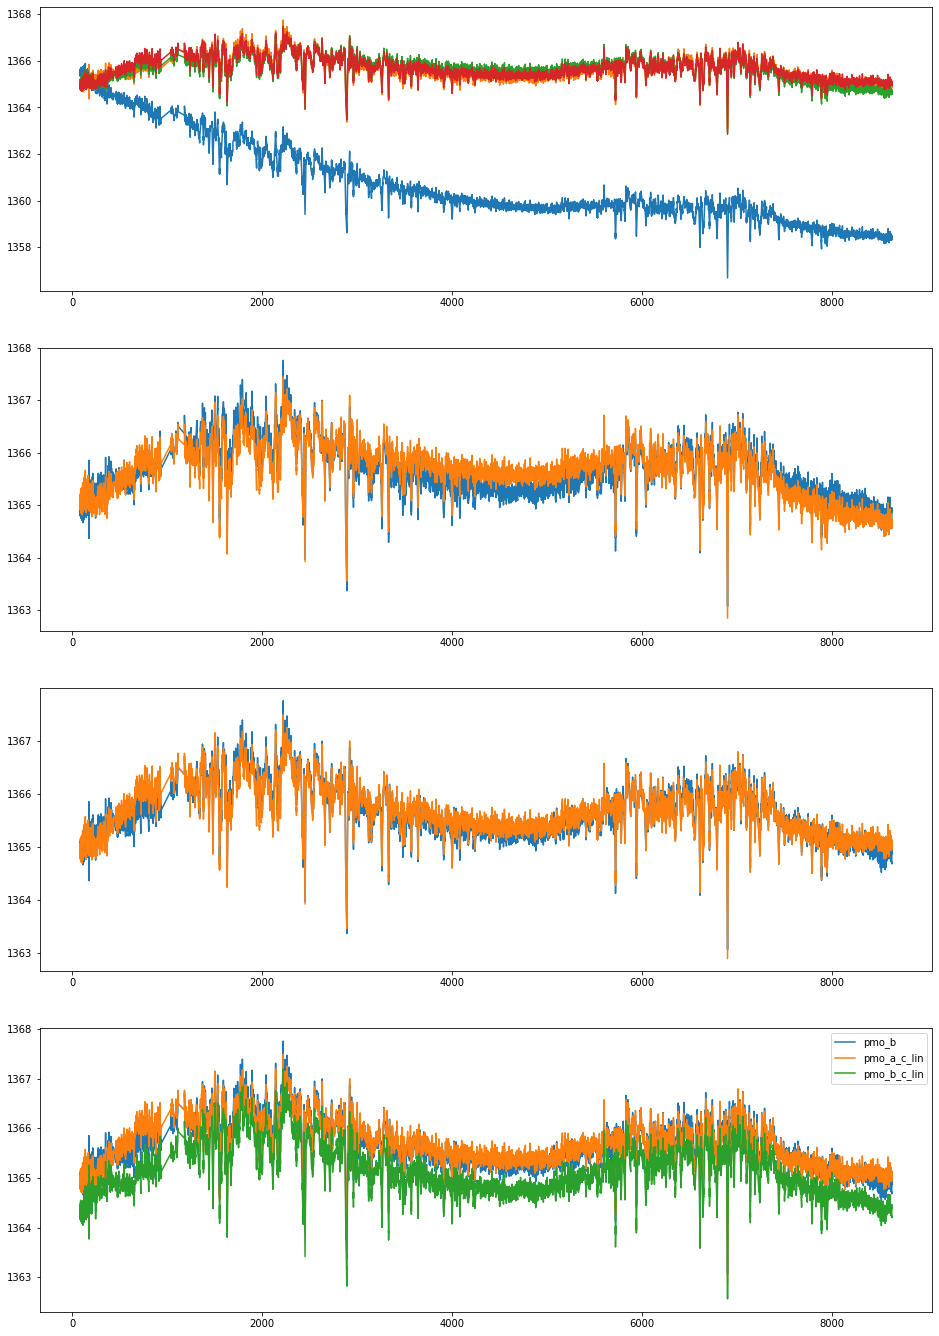

In [80]:
x_a_nn_c = x_a_nn / exponential_model(e_a_nn, *popt)
x_a_nn_c_lin = x_a_nn / exponential_linear_model(e_a_nn, *popt_lin)

x_b_nn_c = x_b_nn / exponential_model(e_b_nn, *popt)
x_b_nn_c_lin = x_b_nn / exponential_linear_model(e_b_nn, *popt_lin)


plt.figure(3, figsize=(16, 24))
plt.subplot(4, 1, 1)
plt.plot(t_nn, x_a_nn, t_nn, x_b_nn, t_nn, x_a_nn_c, t_nn, x_a_nn_c_lin)
plt.subplot(4, 1, 2)
plt.plot(t_nn, x_b_nn, t_nn, x_a_nn_c)
plt.subplot(4, 1, 3)
plt.plot(t_nn, x_b_nn, t_nn, x_a_nn_c_lin)
plt.subplot(4, 1, 4)
plt.plot(t_nn, x_b_nn, t_nn, x_a_nn_c_lin, t_nn, x_b_nn_c_lin)
plt.legend(["pmo_b", "pmo_a_c_lin", "pmo_b_c_lin"])
plt.show()

norm change 11524013.49106319
norm change 215445.53633929417
norm change 4494.0570440888405
norm change 106.92452934384346
norm change 88.61926358006895
norm change 5.8433655351400375
norm change 6.478660529479384
norm change 19.39423279836774
norm change 118.3183057513088
norm change 6.632095394656062
norm change 8.301424140110612
norm change 108.02737064473331
norm change 107.81481902487576
norm change 88.40717931836843
norm change 0.9747589118778706


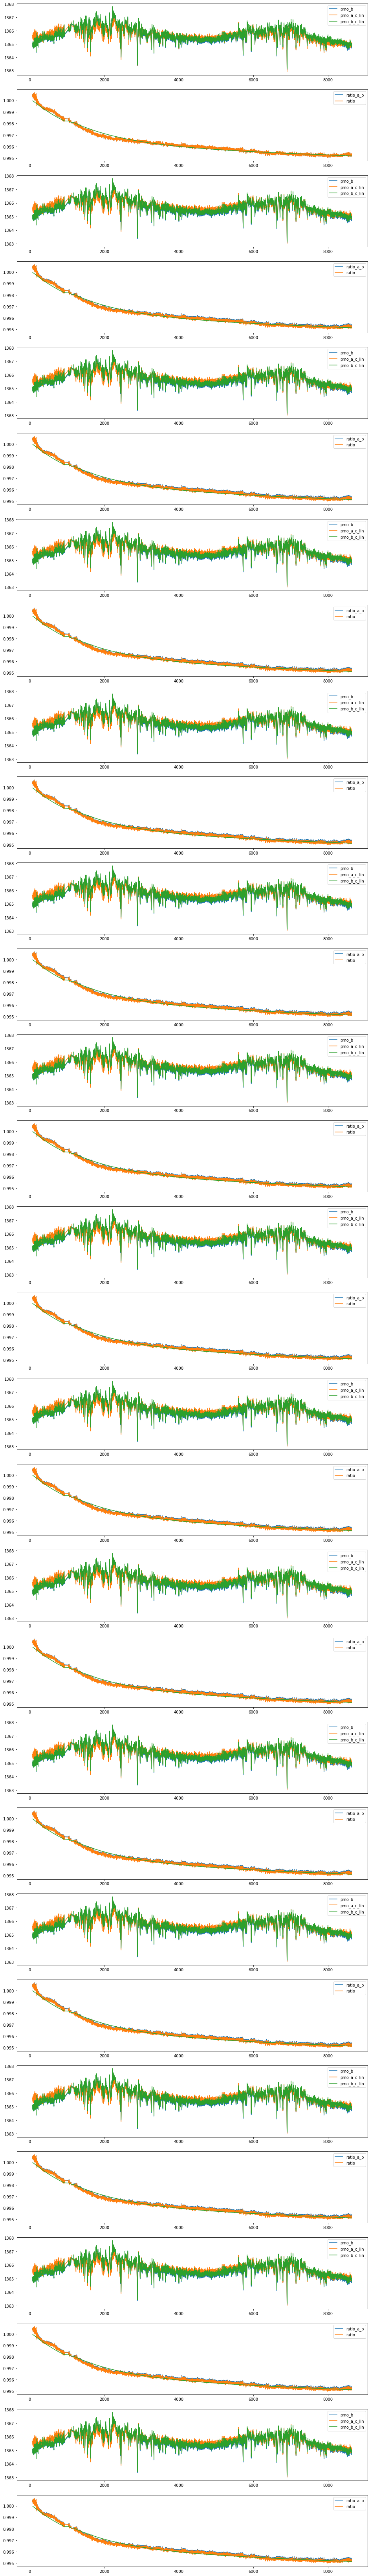

In [93]:

N = 15
ratio = ratio_a_b
x_b_nn_c_lin = x_b_nn

popt = np.zeros(shape=(3,))
for i in range(1, N+1):
    ratio = x_a_nn / x_b_nn_c_lin
    
    popt_lin, _ = curve_fit(exponential_linear_model,  e_a_nn,  ratio, p0=(lambda_, t_0, 0))
    x_a_nn_c_lin = x_a_nn / exponential_linear_model(e_a_nn, *popt_lin)
    x_b_nn_c_lin = x_b_nn / exponential_linear_model(e_b_nn, *popt_lin)


#     popt_lin, _ = curve_fit(exponential_model,  e_a_nn,  ratio, p0=(lambda_, t_0))
#     x_a_nn_c_lin = x_a_nn / exponential_model(e_a_nn, *popt_lin)
#     x_b_nn_c_lin = x_b_nn / exponential_model(e_b_nn, *popt_lin)

    print("norm change", np.linalg.norm(popt - popt_lin))
    popt = popt_lin
    
#     plt.figure(4, figsize=(16, N * 4))
#     plt.subplot(N, 2, 2*(i-1)+1)
#     plt.plot(t_nn, x_b_nn, t_nn, x_a_nn_c_lin, t_nn, x_b_nn_c_lin)
#     plt.legend(["pmo_b", "pmo_a_c_lin", "pmo_b_c_lin"])
#     plt.subplot(N, 2, 2*(i-1)+2)
#     plt.plot(t_nn, ratio_a_b, t_nn, ratio)
#     plt.legend(["ratio_a_b", "ratio"])
    
#     plt.figure(4, figsize=(16, N * 8))
#     plt.subplot(2*N, 1, 2*(i-1)+1)
#     plt.plot(t_nn, x_b_nn, t_nn, x_a_nn_c_lin, t_nn, x_b_nn_c_lin)
#     plt.legend(["pmo_b", "pmo_a_c_lin", "pmo_b_c_lin"])
#     plt.subplot(2*N, 1, 2*(i-1)+2)
#     plt.plot(t_nn, ratio_a_b, t_nn, ratio, t_nn, exponential_linear_model(e_a_nn, *popt))
#     plt.legend(["ratio_a_b", "ratio"])

plt.show()


In [84]:
e_a_nn / e_b_nn

array([15107.83988185,  7554.50312034,  5036.73404209, ...,
         295.97320622,   295.96566428,   295.95812268])